Run the python file and construct the model. 
And import the model to this file for plotting the results

In [12]:
import numpy as np

#Set the `numpy` pseudo-random generator at a fixed value
#This helps with repeatable results everytime you run the code. 
np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras

In [13]:
os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow
#We can also set it to Theano if we want. 

In [14]:
#Iterate through all images in Parasitized folder, resize to 64 x 64
#Then save as numpy array with name 'dataset'
#Set the label to this as 0

image_directory = 'archive/cell_images/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [15]:
parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [16]:
#Apply CNN
# ### Build the model

#############################################################
###2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)
conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation='sigmoid')(drop4)   #units=1 gives error

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',   #Check between binary_crossentropy and categorical_crossentropy
                metrics=['accuracy'])
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248  

In [17]:
### Split the dataset
# 
# I split the dataset into training and testing dataset.
# 1. Training data: 80%
# 2. Testing data: 20%
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

# When training with Keras's Model.fit(), adding the tf.keras.callback.TensorBoard callback 
# ensures that logs are created and stored. Additionally, enable histogram computation 
#every epoch with histogram_freq=1 (this is off by default)
#Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

#import datetime

#log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
# ### Training the model
# As the training data is now ready, I will use it to train the model.   

#Fit the model
history = model.fit(np.array(X_train), 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 30,      #Changed to 3 from 50 for testing purposes.
                         validation_split = 0.1,
                         shuffle = False
                      #   callbacks=callbacks
                     )

Epoch 1/30
311/311 [==============================] - 97s 313ms/step - loss: 0.1781 - accuracy: 0.9386 - val_loss: 0.1684 - val_accuracy: 0.9397
Epoch 2/30
311/311 [==============================] - 94s 303ms/step - loss: 0.1624 - accuracy: 0.9425 - val_loss: 0.1806 - val_accuracy: 0.9383
Epoch 3/30
311/311 [==============================] - 94s 302ms/step - loss: 0.1439 - accuracy: 0.9455 - val_loss: 0.2067 - val_accuracy: 0.9247
Epoch 4/30
311/311 [==============================] - 95s 304ms/step - loss: 0.1286 - accuracy: 0.9527 - val_loss: 0.1985 - val_accuracy: 0.9356
Epoch 5/30
311/311 [==============================] - 94s 304ms/step - loss: 0.1150 - accuracy: 0.9575 - val_loss: 0.1869 - val_accuracy: 0.9333
Epoch 6/30
311/311 [==============================] - 94s 303ms/step - loss: 0.0980 - accuracy: 0.9636 - val_loss: 0.2092 - val_accuracy: 0.9306
Epoch 7/30
311/311 [==============================] - 94s 301ms/step - loss: 0.0813 - accuracy: 0.9719 - val_loss: 0.1813 - val_ac

In [23]:
# ## Accuracy calculation
# 
# I'll now calculate the accuracy on the test data.

print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

173/173 [==============================] - 6s 36ms/step - loss: 0.2834 - accuracy: 0.9563
Test_Accuracy: 95.63%


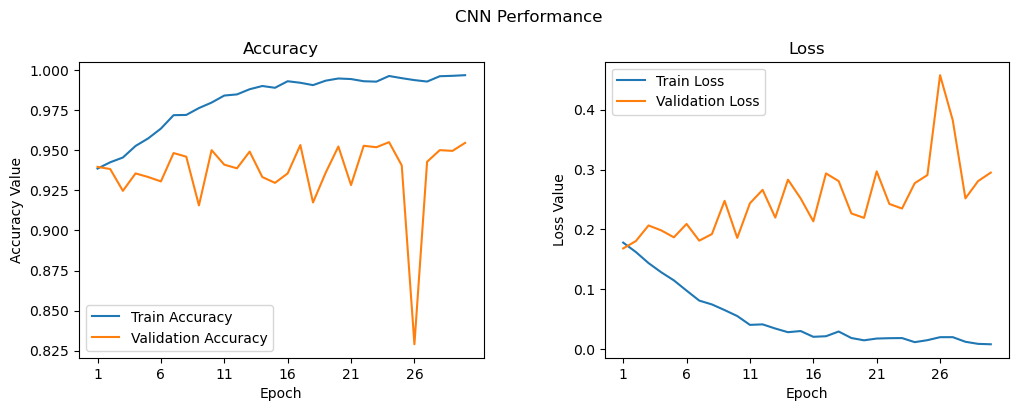

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [25]:
#Save the model
model.save('malaria_cnn.h5')